## Methode Machine learning pour savoir si une image est conforme ou non

### detection et extraction des positions

In [3]:
import cv2
import json

positions = []

# Callback pour gérer les clics souris
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        w, h = 28, 28  # Taille du ROI
        positions.append((x, y, w, h))
        print(f"Position enregistrée : x={x}, y={y}, w={w}, h={h}")
        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow(window_name, img_display)

# --- Charge l'image binarisée du décalque ---
image_path = "data/clean_image/30mm_BonW_14.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"L'image '{image_path}' n'a pas été trouvée.")

img_display = img.copy()

# --- Crée une fenêtre redimensionnable ---
window_name = "Clique sur les chiffres"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.imshow(window_name, img_display)
cv2.setMouseCallback(window_name, click_event)

print("🖱️ Clique sur chaque chiffre à extraire (ROI 28x28).")
print("❌ Appuie sur 'q' pour terminer et fermer.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# --- Sauvegarde les positions dans un fichier JSON ---
with open("positions_chiffres.json", "w") as f:
    json.dump(positions, f)

print("✅ Positions sauvegardées dans 'positions_chiffres.json'")


🖱️ Clique sur chaque chiffre à extraire (ROI 28x28).
❌ Appuie sur 'q' pour terminer et fermer.
Position enregistrée : x=2199, y=3521, w=28, h=28
Position enregistrée : x=2480, y=3489, w=28, h=28
Position enregistrée : x=2754, y=3367, w=28, h=28
Position enregistrée : x=3010, y=3264, w=28, h=28
Position enregistrée : x=3168, y=3065, w=28, h=28
Position enregistrée : x=3406, y=2808, w=28, h=28
Position enregistrée : x=3438, y=2525, w=28, h=28
Position enregistrée : x=3571, y=2313, w=28, h=28
Position enregistrée : x=3553, y=1985, w=28, h=28
Position enregistrée : x=3501, y=1773, w=28, h=28
Position enregistrée : x=3350, y=1484, w=28, h=28
Position enregistrée : x=3255, y=1311, w=28, h=28
Position enregistrée : x=3038, y=1041, w=28, h=28
Position enregistrée : x=2782, y=848, w=28, h=28
Position enregistrée : x=2540, y=855, w=28, h=28
Position enregistrée : x=2298, y=694, w=28, h=28
Position enregistrée : x=2045, y=694, w=28, h=28
Position enregistrée : x=1747, y=739, w=28, h=28
Position e

### Binarisation des images 

In [ ]:
import cv2
import os
import numpy as np
from pathlib import Path

def binarize_folder(input_folder, output_folder):
    # Vérification et création du dossier de sortie
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Filtres d'extension d'image
    image_files = [f for f in os.listdir(input_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Aucune image trouvée dans {input_folder}")
        return

    for image_name in image_files:
        input_path = os.path.join(input_folder, image_name)
        output_path = os.path.join(output_folder, image_name)

        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"[❌] Erreur : Impossible de charger {image_name}")
            continue

        # Binarisation 
        thresh_adaptive = cv2.adaptiveThreshold(
            img, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            11,
            2
        )

        # Enregistrement
        cv2.imwrite(output_path, thresh_adaptive)
        print(f"[✅] {image_name} → sauvegardée dans {output_folder}")

    print("\n🎉 Traitement terminé.")

# === EXEMPLE D'UTILISATION ===
input_folder = "test"
output_folder = "test_binarized"
binarize_folder(input_folder, output_folder)


### Preparation des données : création des ROIS

In [ ]:
import cv2
import os
import json
import numpy as np
from pathlib import Path

# === PARAMÈTRES ===
input_folder = "test_binarized"   # 📁 Images binarisées (28x28)
output_folder = "roi_images"        # 📁 Dossier des ROI
coord_file = "positions_chiffres.json"   # 📄 Coordonnées (JSON ou TXT)
roi_size = (28, 28)                      # 🎯 Taille finale de chaque ROI
padding_color = 255                      # 🧼 Blanc pour fond

# === CHARGEMENT DES COORDONNÉES ===
coords = []
if coord_file.endswith(".json"):
    with open(coord_file, "r") as f:
        coords = [tuple(coord) for coord in json.load(f)]
elif coord_file.endswith(".txt"):
    with open(coord_file, "r") as f:
        coords = [tuple(map(int, line.strip().split(","))) for line in f]
else:
    raise ValueError("Fichier de coordonnées non supporté (JSON ou TXT uniquement).")

# === CRÉATION DU DOSSIER DE SORTIE ===
Path(output_folder).mkdir(parents=True, exist_ok=True)

# === LECTURE DES IMAGES ===
image_files = [f for f in os.listdir(input_folder)
               if f.lower().endswith((".png", ".jpg", ".jpeg"))]

if not image_files:
    print(f"Aucune image trouvée dans {input_folder}")
    exit()

for img_index, img_name in enumerate(image_files):
    img_path = os.path.join(input_folder, img_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"[❌] Erreur de chargement : {img_name}")
        continue

    for roi_index, (x, y, w, h) in enumerate(coords):
        # === GESTION DU DÉBORDEMENT (hors image) ===
        roi = np.full((h, w), padding_color, dtype=np.uint8)

        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, image.shape[1]), min(y + h, image.shape[0])

        crop = image[y1:y2, x1:x2]

        roi_y1 = max(0, -y)
        roi_x1 = max(0, -x)
        roi[roi_y1:roi_y1 + crop.shape[0], roi_x1:roi_x1 + crop.shape[1]] = crop

        roi_resized = cv2.resize(roi, roi_size)

        # === Sauvegarde du fichier ===
        roi_filename = f"{Path(img_name).stem}_roi{roi_index:02}.png"
        roi_path = os.path.join(output_folder, roi_filename)
        cv2.imwrite(roi_path, roi_resized)

    print(f"[✅] {img_name} → {len(coords)} ROI extraits")

print("\n🎯 Extraction terminée.")


### Labelisation des images 

In [14]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os
import shutil
from pathlib import Path

# === PARAMÈTRES ===
roi_folder = "roi_images"  # Dossier contenant les ROI à trier
conforme_folder = os.path.join(roi_folder, "conforme")
non_conforme_folder = os.path.join(roi_folder, "non_conforme")

# === CRÉATION DES DOSSIERS DE CLASSEMENT ===
Path(conforme_folder).mkdir(parents=True, exist_ok=True)
Path(non_conforme_folder).mkdir(parents=True, exist_ok=True)

# === LISTE DES IMAGES À TRIER ===
images = [f for f in os.listdir(roi_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# === INTERFACE ===
class TriROI:
    def __init__(self, master):
        self.master = master
        self.master.title("Interface de tri des ROI")
        self.index = 0
        self.image_label = tk.Label(master)
        self.image_label.pack()

        # Boutons
        btn_frame = tk.Frame(master)
        btn_frame.pack(pady=10)

        btn_c = tk.Button(btn_frame, text="✅ Conforme (C)", command=self.mark_conforme, width=20)
        btn_nc = tk.Button(btn_frame, text="❌ Non Conforme (N)", command=self.mark_non_conforme, width=20)
        btn_c.pack(side=tk.LEFT, padx=10)
        btn_nc.pack(side=tk.RIGHT, padx=10)

        # Raccourcis clavier
        master.bind("<c>", lambda e: self.mark_conforme())
        master.bind("<n>", lambda e: self.mark_non_conforme())

        self.show_image()

    def show_image(self):
        if self.index >= len(images):
            self.image_label.config(text="🎉 Tri terminé.")
            return

        img_path = os.path.join(roi_folder, images[self.index])
        image = Image.open(img_path)
        image = image.resize((200, 200))  # Resize pour affichage
        self.photo = ImageTk.PhotoImage(image)

        self.image_label.config(image=self.photo)
        self.image_label.image = self.photo

    def move_image(self, destination_folder):
        src = os.path.join(roi_folder, images[self.index])
        dst = os.path.join(destination_folder, images[self.index])
        shutil.move(src, dst)
        self.index += 1
        self.show_image()

    def mark_conforme(self):
        self.move_image(conforme_folder)

    def mark_non_conforme(self):
        self.move_image(non_conforme_folder)

# === LANCEMENT ===
if __name__ == "__main__":
    root = tk.Tk()
    app = TriROI(root)
    root.mainloop()


### Entrainement du model pour détecter un chiffre manquant




Epoch 1/10


8/8 [==============================] - 4s 83ms/step - loss: 0.3668 - accuracy: 0.7531 - val_loss: 0.2645 - val_accuracy: 0.8500
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 0.2450 - accuracy: 0.9079 - val_loss: 0.3138 - val_accuracy: 0.9500
Epoch 3/10
8/8 [==============================] - 0s 24ms/step - loss: 0.2387 - accuracy: 0.9498 - val_loss: 0.2281 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 0s 23ms/step - loss: 0.2166 - accuracy: 0.9833 - val_loss: 0.1629 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 0s 23ms/step - loss: 0.1680 - accuracy: 0.9833 - val_loss: 0.1024 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 0s 24ms/step - loss: 0.1000 - accuracy: 0.9833 - val_loss: 0.0321 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 0s 25ms/step - loss: 0.1045 - accuracy: 0.9833 - val_loss: 0.0681 - val_accuracy: 1.0000
Epoch 8/10
8/8 [======

c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


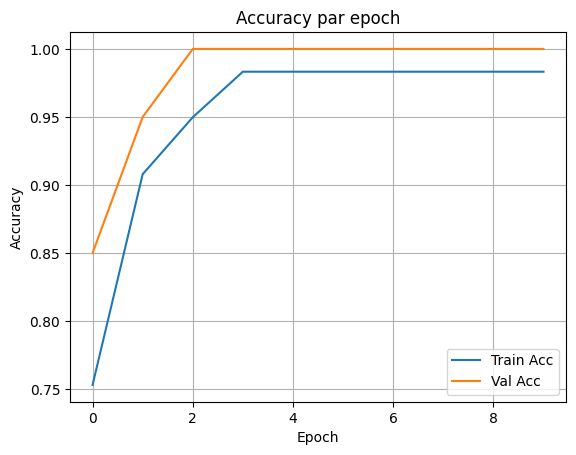

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# === PARAMÈTRES ===
img_size = 28
dataset_path = "roi_images"
classes = ["conforme", "non_conforme"]

# === CHARGEMENT DES IMAGES ===
X = []
y = []

for idx, label in enumerate(classes):
    class_folder = os.path.join(dataset_path, label)
    for file in os.listdir(class_folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)

X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0  # Normalisation
y = to_categorical(y, num_classes=2)

# === DIVISION TRAIN/TEST ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODELE CNN SIMPLE ===
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes
])

# === COMPILATION ===
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# === ENTRAINEMENT ===
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# === EVALUATION ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.2%}")
model.save("cnn_conformite_model.h5")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Methode de centres de gravités pour vérifier si une image est conforme ou non

In [ ]:
import cv2
import numpy as np
import os

# Coordonnées des rectangles (inchangées)
rectangles = [
    {'x': 2060, 'y': 3366, 'width': 248, 'height': 355},
    {'x': 2358, 'y': 3344, 'width': 259, 'height': 315},
    {'x': 2617, 'y': 3282, 'width': 265, 'height': 309},
    {'x': 2820, 'y': 3152, 'width': 304, 'height': 265},
    {'x': 2967, 'y': 2944, 'width': 343, 'height': 287},
    {'x': 3220, 'y': 2679, 'width': 298, 'height': 316},
    {'x': 3316, 'y': 2409, 'width': 292, 'height': 327},
    {'x': 3361, 'y': 2184, 'width': 337, 'height': 225},
    {'x': 3349, 'y': 1942, 'width': 361, 'height': 191},
    {'x': 3316, 'y': 1610, 'width': 343, 'height': 304},
    {'x': 3265, 'y': 1317, 'width': 304, 'height': 338},
    {'x': 3085, 'y': 1069, 'width': 332, 'height': 349},
    {'x': 2854, 'y': 867, 'width': 355, 'height': 360},
    {'x': 2662, 'y': 686, 'width': 305, 'height': 372},
    {'x': 2409, 'y': 641, 'width': 282, 'height': 355},
    {'x': 2116, 'y': 579, 'width': 327, 'height': 366},
    {'x': 1812, 'y': 613, 'width': 344, 'height': 299},
    {'x': 1548, 'y': 647, 'width': 349, 'height': 321},
    {'x': 1311, 'y': 737, 'width': 316, 'height': 343},
    {'x': 1069, 'y': 945, 'width': 327, 'height': 299},
    {'x': 867, 'y': 1142, 'width': 320, 'height': 333},
    {'x': 731, 'y': 1368, 'width': 321, 'height': 321},
    {'x': 602, 'y': 1621, 'width': 360, 'height': 326},
    {'x': 591, 'y': 1902, 'width': 326, 'height': 338},
    {'x': 579, 'y': 2223, 'width': 361, 'height': 287},
    {'x': 669, 'y': 2505, 'width': 350, 'height': 287},
    {'x': 816, 'y': 2747, 'width': 338, 'height': 259},
    {'x': 1002, 'y': 2938, 'width': 326, 'height': 344},
    {'x': 1232, 'y': 3158, 'width': 304, 'height': 310},
    {'x': 1503, 'y': 3287, 'width': 281, 'height': 288},
    {'x': 1773, 'y': 3299, 'width': 338, 'height': 529}
]

# Analyse de conformité d'une ROI
def is_defective(roi, seuil_masse=1000, seuil_distance=50):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    moments = cv2.moments(thresh)
    masse = moments['m00']

    if masse < seuil_masse:
        return True, None  # vide ou trop léger

    try:
        cx = int(moments['m10'] / masse)
        cy = int(moments['m01'] / masse)
    except ZeroDivisionError:
        return True, None

    h, w = gray.shape
    gx, gy = w // 2, h // 2
    distance = np.sqrt((cx - gx)**2 + (cy - gy)**2)

    defect = distance > seuil_distance
    return defect, (cx, cy)

# Fonction principale avec rapport global
def extract_and_check_rois(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur de lecture de l'image : {image_path}")
        return

    output_dir = "extracted_rois"
    os.makedirs(output_dir, exist_ok=True)

    conform_count = 0
    total = len(rectangles)

    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        roi = image[y:y+h, x:x+w]

        if roi.size == 0 or roi.shape[0] == 0 or roi.shape[1] == 0:
            roi = 255 * np.ones((h, w, 3), dtype=np.uint8)
            conform = False
            centroid = None
        else:
            defective, centroid = is_defective(roi)
            conform = not defective

        if conform:
            conform_count += 1

        if centroid:
            cv2.circle(roi, centroid, 5, (0, 0, 255), -1)

        label = "CONFORME" if conform else "NON_CONFORME"
        filename = f"roi_{i+1:02d}_{label}.png"
        path = os.path.join(output_dir, filename)
        cv2.imwrite(path, roi)
        

    # Résumé global
    print("\n--- BILAN FINAL ---")
    if conform_count == total:
        print("✅ Le décalque est CONFORME.")
    else:
        print("❌ Le décalque est NON CONFORME.")





### Test des 2 méthode : ML et centre de gravité 

In [31]:
import cv2
import os
import numpy as np



def binarize_image(input_image_path, output_image_path):
    if not os.path.exists(input_image_path):
        print(f"Erreur : L'image d'entrée {input_image_path} n'existe pas.")
        exit()
    img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {input_image_path}")
        exit()

    thresh_adaptive = cv2.adaptiveThreshold(
        img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  
        cv2.THRESH_BINARY_INV,          
        11,                             
        2                               
    )
    _, thresh_otsu = cv2.threshold(
        img, 0, 255, 
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU  
    )

    thresh = thresh_adaptive
    cv2.imwrite(output_image_path, thresh)
    print(f"Image binarisée sauvegardée sous {output_image_path}")



# Chemin de l'image d'entrée
input_image_path = "data/clean_image/30mm_BonW_9.jpg"
# Chemin pour sauvegarder l'image binarisée
output_image_path = "binarized_image.jpg"
binarize_image(input_image_path, output_image_path)

Image binarisée sauvegardée sous binarized_image.jpg


### Extraction des roi en vue de test v1

In [38]:
import cv2
import os
import numpy as np
from pathlib import Path
import json

def extract_rois_from_image(image_path, coords_path, roi_size=(28, 28), padding_color=255):
    """
    Extrait les ROI à partir d'une image unique selon des coordonnées données
    et les enregistre dans un dossier.

    :param image_path: Chemin vers l'image source
    :param coords_path: Fichier contenant les coordonnées des ROI (JSON ou TXT)
    
    :param roi_size: Taille finale des ROI (width, height)
    :param padding_color: Couleur utilisée si le ROI dépasse l'image (blanc par défaut)
    """
    # Charger l’image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"[❌] L'image '{image_path}' n'a pas pu être chargée.")

    # Charger les coordonnées
    if coords_path.endswith(".json"):
        with open(coords_path, "r") as f:
            coords = [tuple(coord) for coord in json.load(f)]
    elif coords_path.endswith(".txt"):
        with open(coords_path, "r") as f:
            coords = [tuple(map(int, line.strip().split(","))) for line in f]
    else:
        raise ValueError("Format de fichier de coordonnées non supporté (utilise .json ou .txt).")

    # Créer le dossier de sortie
    

    for idx, (x, y, w, h) in enumerate(coords):
        # Zone à remplir par du blanc
        roi = np.full((h, w), padding_color, dtype=np.uint8)

        # Calculer la zone valide dans l’image
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, image.shape[1]), min(y + h, image.shape[0])

        # Découpe de la zone valide
        crop = image[y1:y2, x1:x2]

        # Position dans le ROI (si padding nécessaire)
        roi_y1 = max(0, -y)
        roi_x1 = max(0, -x)
        roi[roi_y1:roi_y1 + crop.shape[0], roi_x1:roi_x1 + crop.shape[1]] = crop

        # Redimensionner si nécessaire
        roi_resized = cv2.resize(roi, roi_size)

        

    print(f"[✅] {len(coords)} ROI extraits depuis '{Path(image_path).name}' dans '{output_dir}'")
extract_rois_from_image(
    image_path="binarized_image.jpg",
    coords_path="positions_chiffres.json"
)
# === EXEMPLE D'UTILISATION ===


[✅] 31 ROI extraits depuis 'binarized_image.jpg' dans 'extracted_rois'


### Test du model

In [39]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# === PARAMÈTRES ===
IMG_SIZE = 28
MODEL_PATH = "cnn_conformite_model.h5"
CLASS_NAMES = ["conforme", "non_conforme"]
CONFIDENCE_THRESHOLD = 0.9  # Seuil de confiance

def load_and_prepare_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

def main(folder_path):
    model = load_model(MODEL_PATH)
    is_non_conforme = False  # Drapeau pour la conclusion finale

    print("\n📊 Analyse des ROI...\n")

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(folder_path, filename)
            img_input = load_and_prepare_image(filepath)

            if img_input is None:
                print(f"{filename} : image non valide")
                continue

            prediction = model.predict(img_input, verbose=0)
            class_index = np.argmax(prediction)
            confidence = prediction[0][class_index]

            result = CLASS_NAMES[class_index]
            confidence_str = f"{confidence:.2%}"

            if result == "non_conforme" and confidence >= CONFIDENCE_THRESHOLD:
                print(f"{filename} ➤ ❌ {result.upper()} ({confidence_str})")
                is_non_conforme = True
            else:
                print(f"{filename} ➤ ✅ {result.upper()} ({confidence_str})")

    print("\n🧾 Conclusion globale :")
    if is_non_conforme:
        print("❌ L'image est jugée NON CONFORME.")
    else:
        print("✅ L'image est jugée CONFORME.")

# === Point d'entrée ===
folder_path = "extracted_rois"
if os.path.isdir(folder_path):
    main(folder_path)
else:
    print("Erreur : le dossier n'existe pas.")



print("------------------------Methode centre de gravité ------------------")
# Exemple d’appel
extract_and_check_rois("data/clean_image/30mm_BonW_9.jpg")


📊 Analyse des ROI...

30mm_WonB_1_resized_copy1_copy1_roi00.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi01.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi02.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi03.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi04.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi05.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi06.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi07.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi08.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi09.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi10.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi11.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi12.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi13.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resized_copy1_copy1_roi14.png ➤ ✅ CONFORME (92.63%)
30mm_WonB_1_resiz